# 텐서보드를 활용한 모델, 데이터, 트레이닝 시각화

## 텐서보드에 필요한 라이브러리, 데이터셋, 네트워크 구성

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 텐서보드 설정하기
- 텐서보드를 섲어하고 torch.utils에서 텐서보드를 임포트한다.
- 텐서보드에 정보를 쓰기 위한 핵심 객체를 SummaryWriter를 정의

In [3]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1') # runs 폴더가 생성됨

make_grid를 사용해 TensorBoard의 그리드에 이미지를 작성한다.

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Jupyter 이미지 출력 오류를 잡음

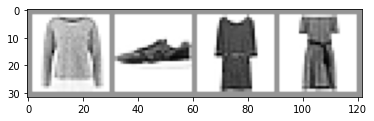

In [6]:
# 트레이닝 데이터 셋을 일부 가져온다.
dataiter = iter(trainloader) # 원래는 for문으로 루프를 구성해야 하나 iter를 사용해서 데이터를 하나만 출력할 수 있다.
images, labels = next(dataiter) 

# 이미지의 그리드를 생성하고 이미지로 확인한다.
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True) # 주피터에 그림을 그림
writer.add_image('four_fashion_mnist_images', img_grid) # runs에 정보를 작성한다.

## 텐서보드를 사용하여 모델 검사

In [8]:
writer.add_graph(net, images)
writer.close()

## 텐서보드에 "프로젝트" 추가하기

In [16]:
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile # 오류 방지용

# 데이터셋에서 n개의 임의의 데이터 포인트와 그에 해당하는 라벨을 선택한다.
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 트레인 데이터셋으로 부터 100개의 데이터 추출
writer = SummaryWriter('runs/fashion_mnist_experiment_1') # runs 폴더가 생성됨
images, labels = select_n_random(trainset.data, trainset.targets)
class_labels = [classes[lab] for lab in labels]
features = images.view(-1, 28*28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1),
                    global_step=111
                   )

writer.close()

## 텐서보드로 모델 학습 추적하기

In [24]:
# 학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다.
def images_to_probs(net, images):
    output = net(images) # 포워드 패스
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    preds, probs= images_to_probs(net, images)
    fig = plt.figure(figsize=(12,48))
    
    for idx in np.arange(4):
        ax = fig.add_subplot(1,4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(
            "{0}, {1:.1f}%\n(labels: {2})".format(
                classes[preds[idx]], probs[idx] * 100.0, classes[labels[idx]]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
        
    return fig

running_loss = 0.0
for epoch in range(1):  # 데이터셋을 여러번 반복
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        
        # 포워드 패스
        outputs = net(inputs) 
        loss = criterion(outputs, labels) # 오류 연산
        
        # 역전파 및 업데이트 수행
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            writer.add_scalar('training loss', running_loss/1000,
                               epoch * len(trainloader) + i)
            
            # 무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
            # Matplotlib Figure를 기록합니다
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


## 텐서보드 서버 구동

In [25]:
# runs에 기록된 정보를 시각화
# 아래 명령을 실행하고 localhost:6006
!tensorboard --logdir=runs

^C
